### Homework 8 PART TWO

RSA and MDS using MNIST

In [21]:
import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.manifold import MDS

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    from tensorflow.keras.datasets import fashion_mnist
    from tensorflow.keras import models
    from tensorflow.keras import layers
    from tensorflow.keras import optimizers
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.models import Model

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

flabels = {0 : 't-shirt',
           1 : 'trousers',
           2 : 'pullover',
           3 : 'dress',
           4 : 'coat',
           5 : 'sandal',
           6 : 'shirt',
           7 : 'sneaker',
           8 : 'bag',
           9 : 'boot'}

In [2]:
# image shape
sz = train_images.shape[1]

# need to reshape and preprocess the training/testing images
train_images_vec = train_images.reshape((train_images.shape[0], train_images.shape[1] * train_images.shape[2]))
train_images_vec = train_images_vec.astype('float32') / 255
test_images_vec = test_images.reshape((test_images.shape[0], test_images.shape[1] * test_images.shape[2]))
test_images_vec = test_images_vec.astype('float32') / 255

# also need to categorically encode the labels
train_labels_onehot = to_categorical(train_labels)
test_labels_onehot = to_categorical(test_labels)

Q2a (1	point).	You	will create	RDMs	and	MDS	solutions	using	five	examples	of	each	of	the	
10	clothing	types	in	the	Fashion-MNIST	dataset	(feel	free	to	adapt	the	code	I	gave	you	for	
the	MNIST	dataset).

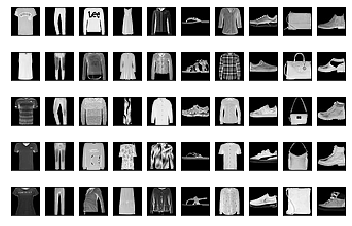

In [3]:
# get 5 examples of each digit

Nexamples = 5
Ndigits = train_labels_onehot.shape[1]
nout = Ndigits

example_images = np.zeros((Ndigits*Nexamples, sz, sz))
for i in range(Ndigits):
    idx = np.where(test_labels==i)[0]
    example_images[i*Nexamples:(i+1)*Nexamples, :, :] = test_images[idx[0:Nexamples], :, :]

idx = 0
fig = plt.figure()
for i in range(Ndigits):
    for j in range(Nexamples):
        plt.subplot(Nexamples,Ndigits,j*Ndigits+i+1)
        plt.imshow(example_images[idx], cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])
        idx = idx+1
plt.show()

example_images_vec = example_images.reshape((example_images.shape[0], example_images.shape[1] * example_images.shape[2]))
example_images_vec = example_images_vec.astype('float32') / 255

Q2b (3 points).	Calculate	and	display	the	RDM	based	on	the	raw	pixel	values	of	the	images	
(the	resulting RDM	will	be	50x50) and	display	a	2D	MDS	solution	from	the	RDM.	I	gave	you	
much	of	the	code	to	get	started	on	this. Make	sure	the	RDM	and	MDS	are	labeled	with	the	
names	of	the	clothing	types.

In [4]:
# calculate RDM for raw pixel images
RDM_Raw = np.zeros((Ndigits*Nexamples, Ndigits*Nexamples))
for i in range(Ndigits*Nexamples):
    for j in range(i, Ndigits*Nexamples):
        a = example_images[i,:,:]
        a = a.reshape((sz*sz))
        b = example_images[j,:,:]
        b = b.reshape((sz*sz))
        r, p = stats.kendalltau(a, b)
        RDM_Raw[i,j] = 1-r
        RDM_Raw[j,i] = 1-r

C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


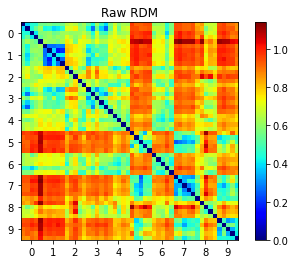

In [5]:
# axis tick locations
xtks = np.arange(np.int(Nexamples/2), Ndigits*Nexamples, Nexamples)
ytks = xtks
xlabs = []
ylabs = []
for i in range(len(xtks)):
    xlabs.append(str(i))
    ylabs.append(str(i))

# plot RDM
fig = plt.figure()
im = plt.imshow(RDM_Raw, cmap='jet', interpolation='none')
plt.title('Raw RDM')
plt.xticks(xtks, xlabs)
plt.yticks(ytks, ylabs)
plt.colorbar(im)
plt.show()

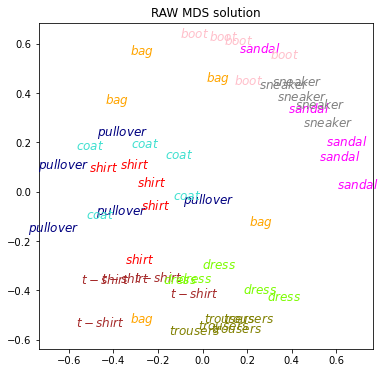

In [8]:
# perform 2D MDS
mdsmodel = MDS(n_components=2, metric=True, 
               dissimilarity='precomputed')
mdssoln = mdsmodel.fit_transform(RDM_Raw)

# labels and colors for digits
dlabs = []
clabs = []
carr = ['brown', 'olive', 'navy', 'lawngreen', 'turquoise',
        'magenta', 'red', 'grey', 'orange', 'pink']
for i in range(Ndigits):
    for j in range(Nexamples):
        dlabs.append(flabels[i])
        clabs.append(carr[i])

plt.figure(figsize=(6,6))
for i in range(Ndigits*Nexamples):
    plt.plot(mdssoln[i,0], mdssoln[i,1], 'w+')
    plt.text(mdssoln[i,0], mdssoln[i,1], 
             r'$ {} $'.format(dlabs[i]), size='large',
             color=clabs[i],
             horizontalalignment='center')
plt.title('RAW MDS solution')
plt.show()

Q2c	(4 points).	Calculate	and	display	the	RDM	based	on	an	early	or	intermediate	layer of	
your	trained	CNN	model	from	Homework	7 (based	on	the	discussion	from	class	and	using	
the	approach	outlined	in	the	ipynb	file	provided) and	display	a	2D	MDS	solution	from	this	
RDM. Make	sure	the	RDM	and	MDS	are	labeled	with	the	names	of	the	clothing	types.

In [10]:
# Reshape the training images to be a flattened 2D representation
base_dim = train_images.shape[1]
new_dim = train_images.shape[1] * train_images.shape[2]
train_2D = np.reshape(train_images, (train_images.shape[0], new_dim))

# Expand the training labels to be 2D
train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))

# Shuffle all vector (THE SAME ORDER)
shuffled_idx = R.permutation(train_2D.shape[0])
train_shuffled = train_2D[shuffled_idx,:]
train_labels_shuffled = train_labels[shuffled_idx,:]

# Take half of the above for the training data for Q1a
train_half = train_shuffled[0:train_shuffled.shape[0]//2]
train_labels_half = train_labels_shuffled[0:train_shuffled.shape[0]//2]

train_imagesREMAKE_shuffled = np.reshape(train_shuffled, (train_shuffled.shape[0],28,28))

input_sz = base_dim

# Reformat images to be "4D"
train_imagesRE1 = train_images.reshape(train_images.shape[0], input_sz, input_sz, 1)
test_imagesRE1 = test_images.reshape(test_images.shape[0], input_sz, input_sz, 1)

# Normalize
train_imagesRE = train_imagesRE1/255
test_imagesRE = test_imagesRE1/255

# need to categorically encode the labels as "one hot"
train_labelsRE = to_categorical(train_labels)
test_labelsRE = to_categorical(test_labels)

print("First 9 training labels as one-hot encoded vectors:\n", train_labelsRE[:9])

Training labels shape:  (60000, 1)
Training labels type:   <class 'numpy.ndarray'>

First 9 training labels as labels:
 [[9]
 [0]
 [0]
 [3]
 [0]
 [2]
 [7]
 [2]
 [5]]

First 9 training labels as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [11]:
network = models.Sequential()
# first convolution layer parameters
num_fm_1 = 16
conv_dim = 3
# second convolution layer parameters
num_fm_2 = 24
# max pooling parameters
mp_dim = 2
nout = 10
# Dense params
dense1 = 40
dense2 = 20

# first convolution layer
network.add(layers.Conv2D(num_fm_1, (conv_dim, conv_dim), 
                          activation='relu', 
                          input_shape=(input_sz, input_sz, 1)))
# max pooling
network.add(layers.MaxPooling2D(mp_dim, mp_dim))

# second convolution layer
network.add(layers.Conv2D(num_fm_1*4, (conv_dim, conv_dim), padding='same'))
# max pooling
network.add(layers.MaxPooling2D(mp_dim, mp_dim))

network.add(layers.Conv2D(num_fm_2*2, (conv_dim,conv_dim), padding='same', activation='relu'))
# max pooling
network.add(layers.MaxPooling2D(mp_dim, mp_dim))

network.add(layers.Conv2D(num_fm_2, (conv_dim,conv_dim), padding='same', activation='relu'))
network.add(layers.Conv2D(num_fm_1, (conv_dim,conv_dim), padding='same', activation='relu'))

network.add(layers.Flatten())
network.add(layers.Dense(dense1, activation='relu'))
network.add(layers.Dense(dense2, activation='relu'))
network.add(layers.Dense(nout, activation='softmax'))

network.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])
network.summary()

history = network.fit(train_imagesRE, train_labelsRE, verbose=False,
                      validation_split=.2, epochs=20, batch_size=256)

test_loss, test_accuracy = network.evaluate(test_imagesRE, test_labelsRE)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 48)          27696     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 48)          0         
____

In [12]:
print('test_acc:', test_accuracy)

test_acc: 0.9007


In [17]:
for layer in network.layers:
    print(f'layer name : {layer.name} | input shape : {layer.input.shape} | output shape : {layer.output.shape}')
print()

layer name : conv2d | input shape : (?, 28, 28, 1) | output shape : (?, 26, 26, 16)
layer name : max_pooling2d | input shape : (?, 26, 26, 16) | output shape : (?, 13, 13, 16)
layer name : conv2d_1 | input shape : (?, 13, 13, 16) | output shape : (?, 13, 13, 64)
layer name : max_pooling2d_1 | input shape : (?, 13, 13, 64) | output shape : (?, 6, 6, 64)
layer name : conv2d_2 | input shape : (?, 6, 6, 64) | output shape : (?, 6, 6, 48)
layer name : max_pooling2d_2 | input shape : (?, 6, 6, 48) | output shape : (?, 3, 3, 48)
layer name : conv2d_3 | input shape : (?, 3, 3, 48) | output shape : (?, 3, 3, 24)
layer name : conv2d_4 | input shape : (?, 3, 3, 24) | output shape : (?, 3, 3, 16)
layer name : flatten | input shape : (?, 3, 3, 16) | output shape : (?, 144)
layer name : dense | input shape : (?, 144) | output shape : (?, 40)
layer name : dense_1 | input shape : (?, 40) | output shape : (?, 20)
layer name : dense_2 | input shape : (?, 20) | output shape : (?, 10)



In [26]:
RE_ex_image = np.reshape(example_images, (50, 28, 28, 1))

layer_name = 'conv2d_3'
intermediate_layer_model = Model(inputs = network.input,  
            outputs = network.get_layer(layer_name).output)
intermediate_output =  intermediate_layer_model.predict(RE_ex_image)
print(intermediate_output.shape)

(50, 3, 3, 24)


In [27]:
io1, io2, io3, io4 = intermediate_output.shape
RE_io = np.reshape(intermediate_output, (io1, io2*io3*io4))

In [39]:
# calculate RDM for raw pixel images
RDM_Inter = np.zeros((io1, io1))
for i in range(io1):
    for j in range(i, io1):
        a = intermediate_output[i,:,:,:] #RE_ex_image[i,:,:]
        a = a.reshape((sz*sz))
        b = intermediate_output[i,:,:,:] #RE_ex_image[j,:,:]
        b = b.reshape((sz*sz))
        r, p = stats.kendalltau(a, b)
        RDM_Inter[i,j] = 1-r
        RDM_Inter[j,i] = 1-r

ValueError: cannot reshape array of size 216 into shape (784,)

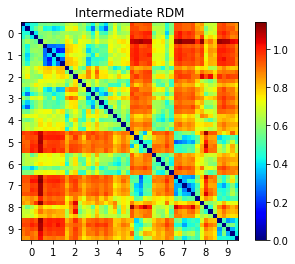

In [38]:
# axis tick locations
xtks = np.arange(Nexamples//2, Ndigits*Nexamples, Nexamples)
ytks = xtks
xlabs = []
ylabs = []
for i in range(len(xtks)):
    xlabs.append(str(i))
    ylabs.append(str(i))

# plot RDM
fig = plt.figure()
im = plt.imshow(RDM_Inter, cmap='jet', interpolation='none')
plt.title('Intermediate RDM')
plt.xticks(xtks, xlabs)
plt.yticks(ytks, ylabs)
plt.colorbar(im)
plt.show()

In [ ]:
# perform 2D MDS
mdsmodel = MDS(n_components=2, metric=True, 
               dissimilarity='precomputed')
mdssoln = mdsmodel.fit_transform(RDM_Raw)

# labels and colors for digits
dlabs = []
clabs = []
carr = ['brown', 'olive', 'navy', 'lawngreen', 'turquoise',
        'magenta', 'red', 'grey', 'orange', 'pink']
for i in range(Ndigits):
    for j in range(Nexamples):
        dlabs.append(flabels[i])
        clabs.append(carr[i])

plt.figure(figsize=(6,6))
for i in range(Ndigits*Nexamples):
    plt.plot(mdssoln[i,0], mdssoln[i,1], 'w+')
    plt.text(mdssoln[i,0], mdssoln[i,1], 
             r'$ {} $'.format(dlabs[i]), size='large',
             color=clabs[i],
             horizontalalignment='center')
plt.title('RAW MDS solution')
plt.show()

Q2d (2	points).	Do	the	same	as	Q2c	but	for	the	penultimate	layer (the	layer	before	the	
classification	layer) of	your	CNN	model	from	Homework 7.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# image shape
sz = train_images.shape[1]

# need to reshape and preprocess the training/testing images
train_images_vec = train_images.reshape((train_images.shape[0], train_images.shape[1] * train_images.shape[2]))
train_images_vec = train_images_vec.astype('float32') / 255
test_images_vec = test_images.reshape((test_images.shape[0], test_images.shape[1] * test_images.shape[2]))
test_images_vec = test_images_vec.astype('float32') / 255

# also need to categorically encode the labels
train_labels_onehot = to_categorical(train_labels)
test_labels_onehot = to_categorical(test_labels)

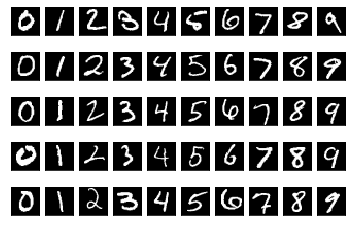

In [2]:
# get 5 examples of each digit

Nexamples = 5
Ndigits = train_labels_onehot.shape[1]
nout = Ndigits

example_images = np.zeros((Ndigits*Nexamples, sz, sz))
for i in range(Ndigits):
    idx = np.where(test_labels==i)[0]
    example_images[i*Nexamples:(i+1)*Nexamples, :, :] = test_images[idx[0:Nexamples], :, :]

idx = 0
fig = plt.figure()
for i in range(Ndigits):
    for j in range(Nexamples):
        plt.subplot(Nexamples,Ndigits,j*Ndigits+i+1)
        plt.imshow(example_images[idx], cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])
        idx = idx+1
plt.show()

example_images_vec = example_images.reshape((example_images.shape[0], example_images.shape[1] * example_images.shape[2]))
example_images_vec = example_images_vec.astype('float32') / 255

In [3]:
# calculate RDM for raw pixel images

from scipy import stats

RDM_Raw = np.zeros((Ndigits*Nexamples, Ndigits*Nexamples))
for i in range(Ndigits*Nexamples):
    for j in range(i, Ndigits*Nexamples):
        a = example_images[i,:,:]
        a = a.reshape((sz*sz))
        b = example_images[j,:,:]
        b = b.reshape((sz*sz))
        r, p = stats.kendalltau(a, b)
        RDM_Raw[i,j] = 1-r
        RDM_Raw[j,i] = 1-r

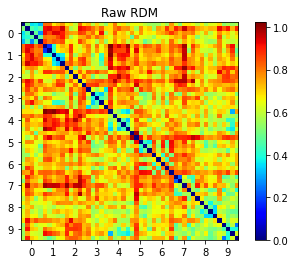

In [4]:
# axis tick locations
xtks = np.arange(np.int(Nexamples/2), Ndigits*Nexamples, Nexamples)
ytks = xtks
xlabs = []
ylabs = []
for i in range(len(xtks)):
    xlabs.append(str(i))
    ylabs.append(str(i))

# plot RDM
fig = plt.figure()
im = plt.imshow(RDM_Raw, cmap='jet', interpolation='none')
plt.title('Raw RDM')
plt.xticks(xtks, xlabs)
plt.yticks(ytks, ylabs)
plt.colorbar(im)
plt.show()

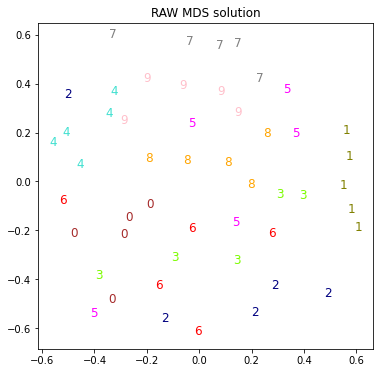

In [5]:
from sklearn.manifold import MDS

# perform 2D MDS
mdsmodel = MDS(n_components=2, metric=True, 
               dissimilarity='precomputed')
mdssoln = mdsmodel.fit_transform(RDM_Raw)

# labels and colors for digits
dlabs = []
clabs = []
carr = ['brown', 'olive', 'navy', 'lawngreen', 'turquoise',
        'magenta', 'red', 'grey', 'orange', 'pink']
for i in range(Ndigits):
    for j in range(Nexamples):
        dlabs.append(str(i))
        clabs.append(carr[i])

plt.figure(figsize=(6,6))
for i in range(Ndigits*Nexamples):
    plt.plot(mdssoln[i,0], mdssoln[i,1], 'w+')
    plt.text(mdssoln[i,0], mdssoln[i,1], 
             r'$ {} $'.format(dlabs[i]), size='large',
             color=clabs[i],
             horizontalalignment='center')
plt.title('RAW MDS solution')
plt.show()

In [6]:
###################################################################
## 
## conv net MNIST classification
##

from tensorflow.keras import models
from tensorflow.keras import layers

# this initializes a blank Sequential network
network = models.Sequential()

# first convolutional layer
# default strides=(1,1)
# default padding is padding='valid' (can also be padding='same')
# network.add(layers.Conv2D(32, (3,3), strides=(1, 1), activation='relu', input_shape=(sz,sz,1)))
network.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(sz,sz,1)))
network.add(layers.MaxPooling2D((2,2)))

# second convolutional layer
network.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
network.add(layers.MaxPooling2D((2,2)))

# third convolutional layer
network.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
network.add(layers.MaxPooling2D((2,2)))

# flatten
network.add(layers.Flatten())

# densely connected layer
network.add(layers.Dense(32, activation='relu'))

# add classification layer
network.add(layers.Dense(nout, activation='softmax'))

2021-11-29 13:13:26.462244: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# print a model summary
print(network.summary())

# print more info about the network
print('*** Basic Network Structure ***')
for layer in network.layers:
    print('layer name : {} | input shape : {} | output shape : {}'.format(layer.name, layer.input.shape, layer.output.shape))
print()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0

In [8]:
# configures the network for training, specifying optimizer and loss function
network.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [9]:
# make sure you compare the dimensions of the training data with the dimensions expected by the network
# in this case, it's expecting input shape : (?, 28, 28, 1)
# but what is the shape of train_images
print(train_images.shape)
train_images = train_images.reshape((train_images.shape[0], 
                                     train_images.shape[1], 
                                     train_images.shape[2], 1))
print(train_images.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [10]:
# now train the network
ep = 5
history = network.fit(train_images,
                      train_labels_onehot,
                      verbose=True,
                      validation_split=.1,
                      epochs=ep,
                      batch_size=128)

2021-11-29 13:13:45.789715: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
422/422 [==============================] - 13s 30ms/step - loss: 0.8798 - accuracy: 0.7469 - val_loss: 0.2215 - val_accuracy: 0.9373
Epoch 2/5
422/422 [==============================] - 12s 29ms/step - loss: 0.1796 - accuracy: 0.9468 - val_loss: 0.1332 - val_accuracy: 0.9643
Epoch 3/5
422/422 [==============================] - 13s 31ms/step - loss: 0.1109 - accuracy: 0.9664 - val_loss: 0.0887 - val_accuracy: 0.9765
Epoch 4/5
422/422 [==============================] - 14s 34ms/step - loss: 0.0769 - accuracy: 0.9758 - val_loss: 0.0783 - val_accuracy: 0.9792
Epoch 5/5
422/422 [==============================] - 16s 39ms/step - loss: 0.0618 - accuracy: 0.9805 - val_loss: 0.0662 - val_accuracy: 0.9828


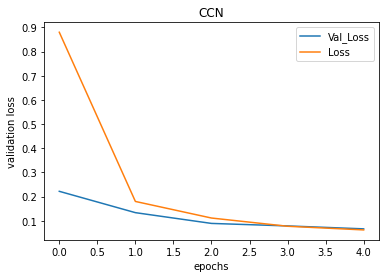

In [11]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.title('CCN')
plt.legend(('Val_Loss', 'Loss'))
plt.show()

In [12]:
print(example_images.shape)
example_images = example_images.reshape((example_images.shape[0],
                                         example_images.shape[1],
                                         example_images.shape[2], 1))
print(example_images.shape)

(50, 28, 28)
(50, 28, 28, 1)


In [13]:
out = network.predict(example_images)

<hr>

## extract intermediate layer

https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction

In [14]:
from tensorflow.keras.models import Model

layer_name = 'conv2d_1'
intermediate_layer_model = Model(inputs = network.input, 
            outputs = network.get_layer(layer_name).output)

intermediate_output = intermediate_layer_model.predict(example_images)

In [15]:
print(intermediate_output.shape)

(50, 14, 14, 32)


In [16]:
# to compute RDM, will need to first reshape to 50xN array

In [17]:
# then calculate RDM like with pixel example

In [18]:
# display RDM

In [19]:
# perform MDS

In [20]:
# display MDS

In [21]:
# repeat for the penultimate layer of your CNN